In [1]:
import numpy
from stl import mesh

# Using an existing stl file:
your_mesh = mesh.Mesh.from_file('KBottle.stl')

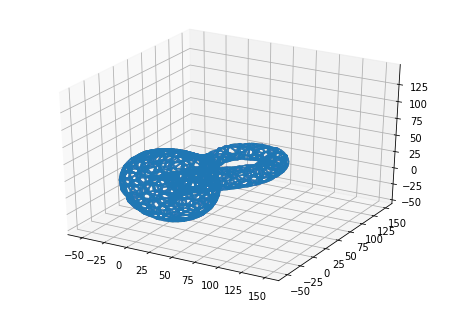

In [54]:
# Create a new plot
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
%matplotlib inline

def plot_triangles(amesh): 
    figure = pyplot.figure()
    axes = mplot3d.Axes3D(figure)
    # Load the STL files and add the vectors to the plot
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(amesh))
    # Auto scale to the mesh size
    scale = amesh.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    # Show the plot to the screen
    pyplot.show()

plot_triangles(your_mesh.vectors)

In [7]:
import torch as tch

In [187]:
def RotToQuat(axes_):
    """
    axes is a ... X 3 3 tensor of axes
    this generates a ... X 4 tensor of quaternions.
    which are 1:1 with those axes.
    """
    w = (1./2.)*tch.sqrt(tch.abs(1 + axes_[...,0, 0] + axes_[...,1, 1] + axes_[...,2, 2]))
    x = tch.sign(axes_[...,2, 1] - axes_[...,1, 2])*tch.abs(0.5*tch.sqrt(tch.abs(1.0 + axes_[...,0, 0] - axes_[...,1, 1] - axes_[...,2, 2])))
    y = tch.sign(axes_[...,0, 2] - axes_[...,2, 0])*tch.abs(0.5*tch.sqrt(tch.abs(1.0 - axes_[...,0, 0] + axes_[...,1, 1] - axes_[...,2, 2])))
    z = tch.sign(axes_[...,1, 0] - axes_[...,0, 1])*tch.abs(0.5*tch.sqrt(tch.abs(1.0 - axes_[...,0, 0] - axes_[...,1, 1] + axes_[...,2, 2])))
    return tch.stack([w,x,y,z], -1)
def QuatToRot(q):
    """
    a_ ... X 4 tensor of quaternions
    this generates a ... X 3 X 3 of rotation matrices.
    """
    tmp=tch.stack([1 - 2.*(q[...,2]*q[...,2] + q[...,3]*q[...,3]), 2*(q[...,1]*q[...,2] - q[...,3]*q[...,0]),
    2*(q[...,1]*q[...,3] + q[...,2]*q[...,0]),2*(q[...,1]*q[...,2] + q[...,3]*q[...,0]), 1 - 2.*(q[...,1]*q[...,1] + q[...,3]*q[...,3]),
    2*(q[...,2]*q[...,3] - q[...,1]*q[...,0]),2*(q[...,1]*q[...,3] - q[...,2]*q[...,0]), 2*(q[...,2]*q[...,3] + q[...,1]*q[...,0]),
    1 - 2.*(q[...,1]*q[...,1] + q[...,2]*q[...,2])],-1)
    return tch.reshape(tmp,[-1,3,3])

def safe_normalize(x_):
    nrm = tch.norm(x_,dim=-1).clamp(1e-36,1e36)
    nrm_ok = (nrm != 0.)
    safe_nrm = tch.where(nrm_ok, nrm, tch.ones_like(nrm))
    return x_*tch.where(nrm_ok,1.0/safe_nrm,tch.zeros_like(nrm))

def safe_inv_norm(x_):
    nrm = tf.clip_by_value(tf.norm(x_,axis=-1,keepdims=True),1e-36,1e36)
    nrm_ok = tf.logical_and(tf.not_equal(nrm,0.),tf.logical_not(tf.is_nan(nrm)))
    safe_nrm = tf.where(nrm_ok,nrm,tf.ones_like(nrm))
    return tf.where(nrm_ok,1.0/safe_nrm,tf.zeros_like(nrm))

def surface_normals(mesh): 
    """
    Returns the surface normals of a mesh. 
    """
    return safe_normalize(tch.cross(mesh[:,1]-mesh[:,0],mesh[:,2]-mesh[:,1]))

def wireframe(mesh, camera=tch.tensor([0.,0,10]), depth = 0.8):
    """
    Simple wireframe projection. 
    https://en.wikipedia.org/wiki/Parallel_projection
    
    Args: 
        mesh: (npoly X 3 X 3) array of polygons
        camera: x,y,z of the camera point. 
    """
    mesh_vectors = mesh.reshape(-1,3)
    mean_point = mesh_vectors.mean(0)
    plane_normal = (mean_point - camera)

    # Solve for the plane lying .9 towards the camera perp to this normal. 
    plane_point = depth*camera - (1.-depth)*mean_point
    plane_d = (plane_point*plane_normal).sum()
    
    v = mesh_vectors - camera
    num = (plane_d - tch.einsum('ij,j->i', mesh_vectors, plane_normal))
    den = tch.einsum('j,ij->i',plane_normal,v)
    corr = tch.einsum('i,ij->ij',(num/(den+1e-14)), v)
    return (mesh_vectors + corr).reshape(-1,3,3)

def visible_polys(mesh, camera): 
    """
    Returns an array of whether a polygon is visible or not 
    to the camera
    
    Args: 
        mesh: (npoly X 3 X 3) array of polygons
        camera: 3x3 array of plane points. 
    """

def exterior_curve(mesh, camera):
    """
    Rapidly find the exterior curve of a polygonal shape. 
    
    1) find the visible polygons based on their centroids
    """

In [188]:
mesh = tch.tensor([
                    [[0.,0,0],[0,1,0],[1,0,0]],
                    [[1.,0,0],[1,1,0],[0,1,0]],
                  [[0.,0,1],[0,1,1],[1,0,1]],
                  [[1.,0,1],[1,1,1],[0,1,1]]
                 ])

In [201]:
wireframe(mesh, camera = tch.tensor([0.,0,14.]))

tensor([[[ 0.0000,  0.0000, 11.1074],
         [ 0.0000,  0.2061, 11.1150],
         [ 0.2061,  0.0000, 11.1150]],

        [[ 0.2061,  0.0000, 11.1150],
         [ 0.2055,  0.2055, 11.1226],
         [ 0.0000,  0.2061, 11.1150]],

        [[ 0.0000,  0.0000, 11.1074],
         [ 0.0000,  0.2219, 11.1156],
         [ 0.2219,  0.0000, 11.1156]],

        [[ 0.2219,  0.0000, 11.1156],
         [ 0.2212,  0.2212, 11.1238],
         [ 0.0000,  0.2219, 11.1156]]])

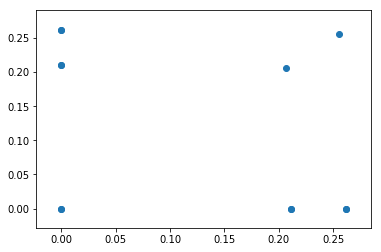

In [209]:
def plot_projected_triangles(amesh, camera = tch.tensor([0.,0,44.])): 
    wp = wireframe(amesh, camera=camera).reshape(-1,3).numpy()
    from matplotlib import pyplot as plt
    plt.scatter(wp[:,0],wp[:,1])
    plt.show()
plot_projected_triangles(mesh, camera = tch.tensor([0.,0, 5.]))

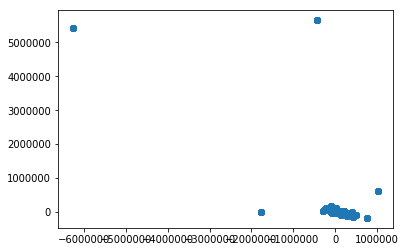

In [199]:
def plot_projected_triangles(amesh, camera = tch.tensor([0.,0,10.])): 
    wp = wireframe(amesh, camera=camera).reshape(-1,3).numpy()
    from matplotlib import pyplot as plt
    plt.scatter(wp[:,0],wp[:,1])
    plt.show()
plot_projected_triangles(tch.tensor(your_mesh.vectors[:].copy()))

In [43]:
safe_normalize(tch.ones(3,3))

tensor([[0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774],
        [0.5774, 0.5774, 0.5774]])

In [75]:
your_mesh[:10].shape

(10, 9)